This notebook is the following part to analysis of the RefinedWeb, analyzed on Google Colab using GPU T4 to deal with advanced NLP techniques.

During this process, the project has not leveraged Spark due to limitation of using Spark **with GPU-based (switching CPU Due to limited GPU), NLP combined with libraries like HuggingFace Transformers and SpaCy, which are not natively supported in distributed Spark environments**.

Instead, NLP techniques has been processed using Pandas to fully utilize GPU acceleration for SpaCy, Sentiment Engine (e.g., HuggingFace Transformers, modelling.

Remarks;
- Intentinally added progress bar due to the long run time monitoring of NLP techniques and to check latency
- Apply `spaCy` for syntactic analysis and dependency parsing  
- Perform sentiment modeling using transformer-based models  
- Test hypotheses based on linguistic structures and sentiment distributions

# Table of Contents

1. [Notebook Setup](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/workspaces/auto-9/tree/digitas-analysis-shared/refinedweb-shared/notebooks/2_refinedweb_analysis_nlp.ipynb#1-Notebook-Setup)

2. [Advanced Text Processing](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/workspaces/auto-9/tree/digitas-analysis-shared/refinedweb-shared/notebooks/2_refinedweb_analysis_nlp.ipynb#2-Advanced-Text-Processing)

3. [Keyword-based Filtering and Additional Feature Engineering](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/workspaces/auto-9/tree/digitas-analysis-shared/refinedweb-shared/notebooks/2_refinedweb_analysis_nlp.ipynb#3-Keyword-based-Filtering-and-Additional-Feature-Engineering)

4. [Keyword Extraction](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/workspaces/auto-9/tree/digitas-analysis-shared/refinedweb-shared/notebooks/2_refinedweb_analysis_nlp.ipynb#4-Keyword-Extraction)  

5. [Sentiment Classification and Modelling](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/workspaces/auto-9/tree/digitas-analysis-shared/refinedweb-shared/notebooks/2_refinedweb_analysis_nlp.ipynb#5-Sentiment-Classification-and-Modelling)

6. [Correlation Analysis](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/workspaces/auto-9/tree/digitas-analysis-shared/refinedweb-shared/notebooks/2_refinedweb_analysis_nlp.ipynb#6-Correlation-Analysis)

7. [Hypothesis Testing](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/workspaces/auto-9/tree/digitas-analysis-shared/refinedweb-shared/notebooks/2_refinedweb_analysis_nlp.ipynb#7-Hypothesis-Testing)

# 1 Notebook Setup


In [ ]:
# HuggingFace Transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Progress bar
from tqdm import tqdm

# File and data utilities
from pathlib import Path
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display, HTML

# Statistics and math
from scipy.special import softmax
from scipy.stats import spearmanr

In [ ]:
# Core libraries
import re
import ast
import numpy as np
import pandas as pd
import psutil
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and Transformers
import spacy
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

ModuleNotFoundError: No module named 'keybert'

In [ ]:
# # (optional) if run in Google Collab
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_parquet('/data/filtered_data/cleaned_nlp_all_brands_2014_2022.parquet')

In [ ]:
df.head()

,url,content,timestamp,year,month,day,full_date,time,url_host,url_domain,url_path,has_ugc_keyword,url_tld,page_length,brand_name,mention_count
0,http://dgettalar.ru/index.php?n=25&id=287606,plain editorial cartoonist watch debate tonigh...,2018-10-15 17:02:05,2018,10,15,2018-10-15,18:02:05,dgettalar.ru,ru/index.php,/index.php,False,ru,659,Zara,1
1,http://www.adayofstyle.com/new-blog/2016/11/16...,season frilled jacquard trouser cute easy matc...,2019-03-18 21:38:57,2019,3,18,2019-03-18,21:38:57,www.adayofstyle.com,adayofstyle.com,/new-blog/2016/11/16/zara-pants,False,com,55,Zara,3
2,https://happyearthpeople.com/2019/01/18/cleans...,recipe zarah zanon tasty dish easy make delici...,2020-09-18 10:10:56,2020,9,18,2020-09-18,11:10:56,happyearthpeople.com,happyearthpeople.com,/2019/01/18/cleanse-approved-green-goodness-ch...,False,com,429,Zara,2
3,https://english.ratopati.com/story/9904,world religion discuss nature life begin man j...,2022-09-24 19:37:28,2022,9,24,2022-09-24,20:37:28,english.ratopati.com,ratopati.com,/story/9904,False,com,1087,Zara,1
4,http://www.turkeymonkey.com/2010/01/25/teds-tw...,twitter update youtube response yele haiti dra...,2019-09-15 15:31:13,2019,9,15,2019-09-15,16:31:13,www.turkeymonkey.com,turkeymonkey.com,/2010/01/25/teds-twitter-updates-for-2010-01-25/,False,com,1189,Zara,1


# 2 Advanced Text Processing

<div style="border-left: 4px solid #cc0000; padding: 1em; background-color: #ffe6e6; border-radius: 4px; margin-top: 1em;">
  <strong>⚠️ Warning:</strong><br><br>
  This process may take a significant amount of time to complete — potentially up to several days — due to model inference latency, system resource constraints, or unexpected runtime issues (e.g., Java heap space errors, Spark job failures, or kernel crashes) if the instance have no GPU and use only CPU.<br><br>

  If sentiment analysis steps are interrupted, rerunning the process may be required from the beginning.<br><br>

  <em>Note: The separator cell below is intentionally added to help you pause and verify environment readiness before proceeding.</em>
</div>


In [ ]:
("🚫 STOP: Please ensure to proceed the next steps below.")

## SpaCy

**SpaCy** is a fast, open-source library for advanced **Natural Language Processing (NLP)** in Python. Key Features includes as below;
- **Tokenization** – Split text into words
- **Lemmatization** – Reduce words to their base form
- **Part-of-Speech Tagging** – Identify word types (noun, verb, etc.)
- **Named Entity Recognition (NER)** – Detect names, places, dates, etc.
- **Dependency Parsing** – Understand sentence structure


SpaCy Named Entity Recognition (NER) Labels

| Label | Description |
|-------|-------------|
| PERSON     | People, including fictional |
| NORP       | Nationalities, religious and political groups |
| FAC        | Facilities (e.g., buildings, airports, highways) |
| ORG        | Organizations (e.g., companies, agencies, institutions) |
| GPE        | Countries, cities, states (Geopolitical Entities) |
| LOC        | Non-GPE locations (e.g., mountain ranges, bodies of water) |
| PRODUCT    | Products (e.g., vehicles, devices, food) |
| EVENT      | Named events (e.g., World War II, Olympics) |
| WORK_OF_ART| Titles of creative works (books, songs, films) |
| LAW        | Named legal documents (e.g., treaties, laws) |
| LANGUAGE   | Any named language |
| DATE       | Absolute or relative dates (e.g., "2022", "next week") |
| TIME       | Times smaller than a day (e.g., "2 PM", "morning") |
| PERCENT    | Percentage values (e.g., "50%") |
| MONEY      | Monetary values (e.g., "$100", "€20") |
| QUANTITY   | Measurements (e.g., "10 kg", "5 miles") |
| ORDINAL    | First, second, third, etc. |
| CARDINAL   | Numerical values (e.g., "one", "100") |


## Extract entities; Named Entity Recognition (NER)

In [ ]:
nlp = spacy.load("en_core_web_sm")  # Load a small English NLP model from spaCy

doc = nlp("H&M launched a new clothing line in Paris.")

for ent in doc.ents:
    print(ent.text, ent.label_)

H&M ORG
Paris GPE


## Sample from DataFrame

In [ ]:
sample_text = df['content'].iloc[0]  # sample from the first row

doc = nlp(sample_text)

for ent in doc.ents:
    print(ent.text, ent.label_)

tonight TIME
italian NORP
sec ORG
one CARDINAL
american NORP
american college ORG
illinois health insurance individual health insurance illinois group insurance medical insurance medicare ORG
maco ORG
fairleigh dickinson university ORG
manhattan GPE
one CARDINAL
galveston island GPE
trey write high school PERSON
weekly DATE
afghanistan GPE
pakistan GPE
asian NORP
one CARDINAL
american college ORG
hill group ORG
kim PERSON
adam county GPE
american NORP
dru hill dru hill ORG
sisqo nokio PERSON
dru hill ORG


## Apply to all dataframe

Apply batch processing to the entire DataFrame using nlp.pipe which is significant faster than .apply

In [ ]:
# Check RAM before applying NLP techniques
print(f"Available memory: {psutil.virtual_memory().available / 1e9:.2f} GB")

Available memory: 11.65 GB


In [ ]:
texts = df['content'].tolist()
entities = []

for doc in tqdm(nlp.pipe(texts, batch_size=100), total=len(texts)):  # add tqdm wrapper
    entities.append([(ent.text, ent.label_) for ent in doc.ents])

df['entities'] = entities

100%|██████████| 10800/10800 [23:26<00:00,  7.68it/s]


In [ ]:
print(df["entities"].iloc[0])

[('tonight', 'TIME'), ('italian', 'NORP'), ('sec', 'ORG'), ('one', 'CARDINAL'), ('american', 'NORP'), ('american college', 'ORG'), ('illinois health insurance individual health insurance illinois group insurance medical insurance medicare', 'ORG'), ('maco', 'ORG'), ('fairleigh dickinson university', 'ORG'), ('manhattan', 'GPE'), ('one', 'CARDINAL'), ('galveston island', 'GPE'), ('trey write high school', 'PERSON'), ('weekly', 'DATE'), ('afghanistan', 'GPE'), ('pakistan', 'GPE'), ('asian', 'NORP'), ('one', 'CARDINAL'), ('american college', 'ORG'), ('hill group', 'ORG'), ('kim', 'PERSON'), ('adam county', 'GPE'), ('american', 'NORP'), ('dru hill dru hill', 'ORG'), ('sisqo nokio', 'PERSON'), ('dru hill', 'ORG')]


In [ ]:
df["entities"].apply(lambda x: isinstance(x, list) and all(isinstance(i, tuple) and len(i) == 2 for i in x)).all()

np.True_

In [ ]:
# Check data type
type(df["entities"].iloc[0])

list

In [ ]:
df["entities"].iloc[0][0]

('tonight', 'TIME')

In [ ]:
type(df["entities"].iloc[0][0])

tuple

## Text Preprocessing; Lemmatization & Stopwords Removal

In [ ]:
# Redefine your function if needed
def preprocess_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

# Apply with progress bar
df['processed_text'] = df['content'].progress_apply(preprocess_spacy)

  0%|          | 0/10800 [00:00<?, ?it/s]

In [ ]:
# Replace old content features
df["content"] = df["processed_text"]
df = df.drop(columns=["processed_text"])

# 3 Keyword-based Filtering and Additional Feature Engineering

Additional feature engineering has been applied for further filtering and analysis, Decided to remove polarity from VADER cause no insight gains

## is_relevant

In [ ]:
# Define domain-specific keywords for filtering retail/fashion-related pages
keywords = [
    'dress', 'shirt', 't-shirt', 'jeans', 'pants', 'trousers', 'blouse',
    'jacket', 'coat', 'skirt', 'shorts', 'sweater', 'cardigan', 'fashion',
    'trend', 'style', 'sale', 'discount', 'shop', 'shopping', 'quality',
    'cheap', 'price', 'return', 'delivery', 'fit', 'comfortable', 'look'
]

# Define filtering function
def is_relevant(row):
    # Convert content to lowercase
    content = row['content'].lower()

    # Check if any keyword exists in the content
    has_keyword = any(kw in content for kw in keywords)

    # Content must be longer than 50 characters (filter out short/noise content)
    enough_length = len(content) > 50

    # Return True only if all conditions are met
    return has_keyword and enough_length

# Apply filtering to your DataFrame
df['is_relevant'] = df.progress_apply(is_relevant, axis=1)


  0%|          | 0/10800 [00:00<?, ?it/s]

In [ ]:
# filter only is_relevant page
df = df[df["is_relevant"] == True]

## Co-mentioned Brands; Extract brands mentioned in the same page

In [ ]:
# Define a list of target brands we want to track co-mentions for
brands = ["zara", "h&m", "primark"]

# Function to extract co-mentioned brands from a list of named entities
def extract_co_mentions_from_entities(entities, primary_brand):
    mentions = []  # This will hold other brands mentioned in the same text
    for name, label in entities:  # Each entity is a (name, label) tuple, like ('primark', 'ORG')
        name_lower = name.lower()  # Convert entity name to lowercase for case-insensitive comparison
        # Check if the name is one of the known brands, and not the same as the main brand for the row
        if name_lower in brands and name_lower != primary_brand.lower():
            mentions.append(name_lower)  # Add it to the co-mention list
    return list(set(mentions))  # Remove duplicates by converting to a set, then back to a list

# Apply the co-mention extraction function to each row of the DataFrame
df['co_mentioned_brands'] = df.progress_apply(
    lambda row: extract_co_mentions_from_entities(row['entities'], row['brand_name']),
    axis=1  # Apply the function row by row
)

  0%|          | 0/10021 [00:00<?, ?it/s]

In [ ]:
# astype(bool) return False for [], None, or NaN
df[df["co_mentioned_brands"].astype(bool)].head()

,url,content,timestamp,year,month,day,full_date,time,url_host,url_domain,url_path,has_ugc_keyword,url_tld,page_length,brand_name,mention_count,entities,is_relevant,co_mentioned_brands


In [ ]:
# return non-null co_mention_brands
count = df["co_mentioned_brands"].astype(bool).sum()
print(count)

0


No insight gains from co_mention_brands

## Add web_category features

In [ ]:
# Define the categorization function
def categorize_website(row):
    domain = str(row['url_host']).lower()
    url = str(row['url']).lower()

    if re.search(r'cnn|bbc|nytimes|reuters|guardian|forbes|bloomberg|ft\.com|cnbc|npr|washingtonpost|wsj', domain) \
       or re.search(r'/news|/breaking|/politics|/world|/article|/headlines', url):
        return 'News'

    elif re.search(r'/blog|/post|/mypage|/mystory|/user|/forum|/profile|/comment|/thread', url) \
         or re.search(r'wordpress|medium|blogspot|tumblr|livejournal', domain):
        return 'Blogs & Community'

    elif re.search(r'/shop|/product|/buy|/cart|/checkout|/store|/item|/deal|/brand|/collection|/sale|/pricing', url) \
         or re.search(r'amazon|ebay|bestbuy|alibaba|etsy|shopify|shein|zara|nike|adidas', domain):
        return 'E-commerce & Commercial'

    elif re.search(r'\.edu$', domain) \
         or re.search(r'edu|university|college|khanacademy|coursera|edx|mit|harvard|stanford', domain) \
         or re.search(r'/learn|/curriculum|/syllabus|/classroom', url):
        return 'Education'

    elif re.search(r'netflix|hulu|spotify|imdb|rottentomatoes|disney|youtube|vimeo|soundcloud', domain) \
         or re.search(r'/music|/tv|/movies|/video|/trailer|/playlist|/watch', url):
        return 'Media & Entertainment'

    elif re.search(r'\.gov$', domain) \
         or re.search(r'gov|nasa|cdc|whitehouse|senate|house\.gov|europa\.eu', domain) \
         or re.search(r'/regulation|/policy|/bill|/law|/agency', url):
        return 'Government'

    elif re.search(r'reddit|facebook|twitter|tiktok|linkedin|pinterest|instagram|snapchat', domain) \
         or re.search(r'/user|/status|/likes|/shares|/posts', url):
        return 'Social'

    elif re.search(r'/investor|/financial|/annual-report|/results|/statement|/earnings|/balance|/report|/10-k|/sec', url) \
         or re.search(r'nasdaq|bloomberg|yahoo\.finance|marketwatch|investopedia', domain):
        return 'Financial'

    elif re.search(r'wikipedia\.org', domain):
        return 'Education'

    elif re.search(r'mozilla\.org', domain):
        return 'Media & Entertainment'

    elif re.search(r'archive\.org', domain):
        return 'Education'

    elif re.search(r'who\.int', domain):
        return 'Government'

    else:
        return 'Others'

# Apply the function to create a new column
df['web_category'] = df.apply(categorize_website, axis=1)

In [ ]:
df.head()

In [ ]:
df['web_category'].value_counts()

In [ ]:
# Count web categories and exclude 'Others'
category_counts = df['web_category'].value_counts()
category_counts = category_counts[category_counts.index != 'Others']

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Document Count by Web Category (Excluding "Others")')
plt.xlabel('Number of Documents')
plt.ylabel('Web Category')
plt.gca().invert_yaxis()  # Highest count on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
df.info()

## Convert Data to correct category

In [ ]:
# Convert date and time columns
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['full_date'] = pd.to_datetime(df['full_date'], errors='coerce')
df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.time

# Convert numeric columns
numeric_cols = ['year', 'month', 'day', 'page_length', 'mention_count']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert boolean columns
df['has_ugc_keyword'] = df['has_ugc_keyword'].astype(bool)
df['is_relevant'] = df['is_relevant'].astype(bool)

# Remaining object columns should generally stay as string (object) unless a specific conversion is needed

# Verify the changes
print(df.dtypes)

## Save as a checkpoint

**Note:** The code block below might have been intentionally hidden to prevent unintentional multiple downloads during testing of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.

In [ ]:
output_path = Path("data/csv_data/nlp-added-nlp-features-1.csv")
df.to_csv(output_path, index=False)

# 4 Keyword Extraction

## KeyBERT: Keyword Extraction with BERT (Theme-based Insight)

KeyBERT is a minimal and easy-to-use keyword extraction technique that leverages BERT embeddings to identify the most relevant keywords or keyphrases in a document. It uses contextual word embeddings from BERT to compare document embeddings with candidate keyword embeddings, selecting those with the highest semantic similarity.

### Key Features:
- Utilizes pre-trained BERT models for semantic similarity
- Extracts keywords that are contextually relevant
- Supports customization with different embedding models and parameters

In [ ]:
df = pd.read_csv(output_path)

In [ ]:
kw_model = KeyBERT()

df['keywords'] = df['content'].progress_apply(
    lambda x: [kw[0] for kw in kw_model.extract_keywords(x, top_n=5)]
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  0%|          | 0/10021 [00:00<?, ?it/s]

## Save as a checkpoint

**Note:** The code block below might have been intentionally hidden to prevent unintentional multiple downloads during testing of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.

In [ ]:
output_path = Path("data/csv_data/nlp-added-nlp-features-2.csv")
df.to_csv(output_path, index=False)

In [ ]:
df = pd.read_csv(output_path)

In [ ]:
df.head()

,url,content,timestamp,year,month,day,full_date,time,url_host,url_domain,url_path,has_ugc_keyword,url_tld,page_length,brand_name,mention_count,entities,is_relevant,co_mentioned_brands,keywords
0,http://dgettalar.ru/index.php?n=25&id=287606,plain editorial cartoonist watch debate tonigh...,2018-10-15 17:02:05,2018,10,15,2018-10-15,18:02:05,dgettalar.ru,ru/index.php,/index.php,False,ru,659,Zara,1,"[('tonight', 'TIME'), ('italian', 'NORP'), ('s...",True,[],"['cartoonist', 'donkey', 'cartoon', 'zoo', 'he..."
1,http://www.adayofstyle.com/new-blog/2016/11/16...,season frille jacquard trouser cute easy match...,2019-03-18 21:38:57,2019,3,18,2019-03-18,21:38:57,www.adayofstyle.com,adayofstyle.com,/new-blog/2016/11/16/zara-pants,False,com,55,Zara,3,"[('jacquard trouser', 'PERSON'), ('jacquard tr...",True,[],"['sweatshirt', 'balenciaga', 'shoe', 'trouser'..."
2,https://english.ratopati.com/story/9904,world religion discuss nature life begin man j...,2022-09-24 19:37:28,2022,9,24,2022-09-24,20:37:28,english.ratopati.com,ratopati.com,/story/9904,False,com,1087,Zara,1,"[('june', 'DATE'), ('christianity', 'NORP'), (...",True,[],"['mankind', 'hinduism', 'buddhism', 'buddhist'..."
3,http://www.turkeymonkey.com/2010/01/25/teds-tw...,twitter update youtube response yele haiti dra...,2019-09-15 15:31:13,2019,9,15,2019-09-15,16:31:13,www.turkeymonkey.com,turkeymonkey.com,/2010/01/25/teds-twitter-updates-for-2010-01-25/,False,com,1189,Zara,1,"[('haiti', 'GPE'), ('st philadelphia', 'GPE'),...",True,[],"['twitter', 'pothole', 'blog', 'tweetie', 'mar..."
4,http://www.rusliterature.org/the-tale-of-batus...,tale capture ryazan tale capture ryazan docume...,2018-08-14 12:50:37,2018,8,14,2018-08-14,13:50:37,www.rusliterature.org,rusliterature.org,/the-tale-of-batus-capture-of-ryazan/,False,org,2567,Zara,6,"[('pronsk die', 'ORG'), ('david murom', 'PERSO...",True,[],"['ryazan', 'principality', 'nicholas', 'oleg',..."


## Top N words by brand

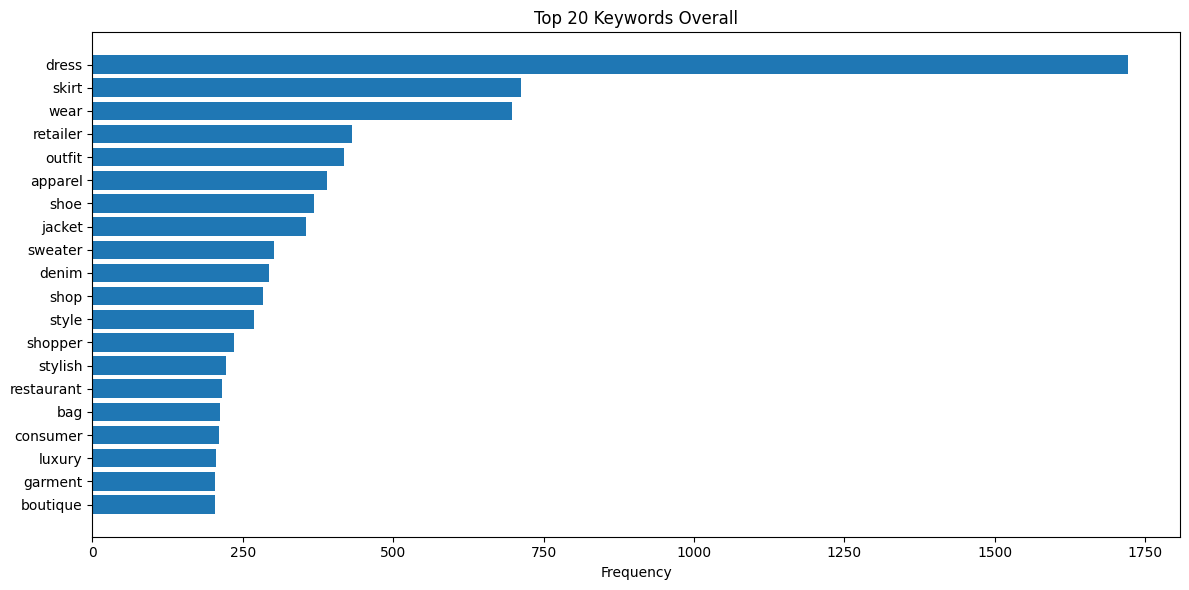

In [ ]:
all_keywords = [kw for kws in df['keywords'] for kw in eval(kws)]
keyword_counts = Counter(all_keywords)

# top 20 keywords
top_keywords = keyword_counts.most_common(20)
labels, values = zip(*top_keywords)

plt.figure(figsize=(12, 6))
plt.barh(labels[::-1], values[::-1])
plt.title("Top 20 Keywords Overall")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

## Filtering out of neutral keyword

Applied further filtering when added feature is_relevant words

In [ ]:
neutral_words = {
    'blouse', 'cardigan', 'coat', 'delivery', 'discount', 'dress',
    'fashion', 'fit', 'jacket', 'jeans', 'look', 'pants', 'price',
    'return', 'sale', 'shirt', 'shop', 'shopping', 'shorts',
    'skirt', 'style', 'sweater', 't-shirt', 'trousers', 'trend','outfit', 'wear'
}

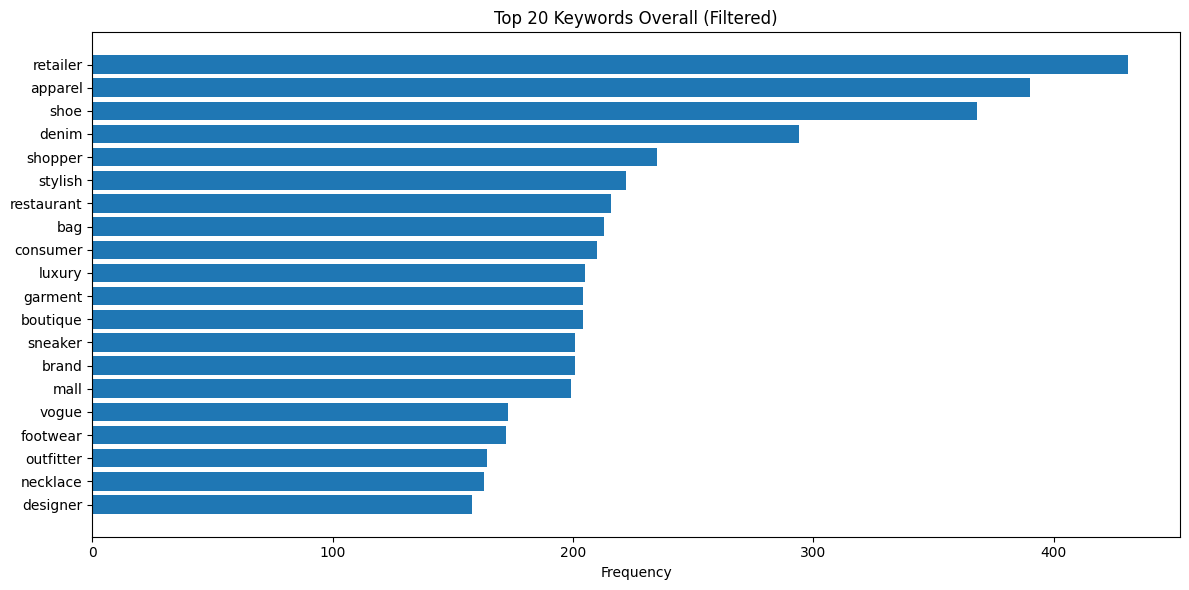

In [ ]:
# Flatten keywords and filter out neutral words
all_keywords = [
    kw for kws in df['keywords']
    for kw in eval(kws)
    if kw not in neutral_words
]

# Count keywords
keyword_counts = Counter(all_keywords)

# Get top 20
top_keywords = keyword_counts.most_common(20)
labels, values = zip(*top_keywords)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(labels[::-1], values[::-1])
plt.title("Top 20 Keywords Overall (Filtered)")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
brand_keywords = df.groupby('brand_name')['keywords'].apply(
    lambda x: [kw for sublist in x for kw in eval(sublist) if kw not in neutral_words]
)

top_brand_keywords = brand_keywords.apply(lambda x: Counter(x).most_common(20))

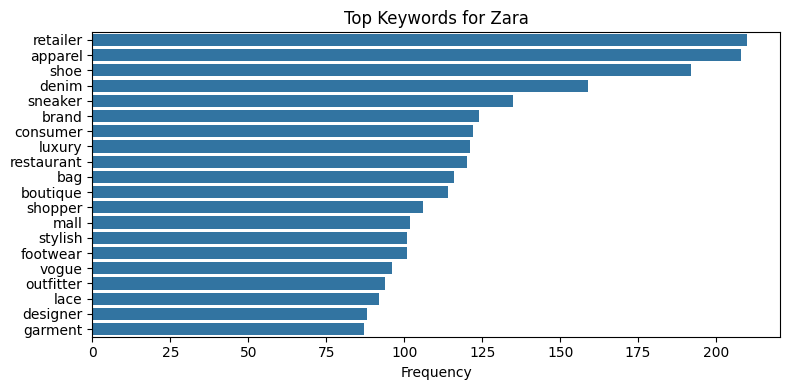

In [ ]:
# Selected brand
import seaborn as sns
brand = "Zara"
keywords = dict(top_brand_keywords[brand])

plt.figure(figsize=(8,4))
sns.barplot(x=list(keywords.values()), y=list(keywords.keys()))
plt.title(f"Top Keywords for {brand}")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
brand = "Zara"
filtered_keywords = [kw for kw in brand_keywords[brand] if kw not in neutral_words]

# Counter to Dataframe
keyword_counts = Counter(filtered_keywords)
df_top_keywords_zara = pd.DataFrame(keyword_counts.most_common(40), columns=["keyword", "count"])

df_top_keywords_zara

,keyword,count
0,retailer,210
1,apparel,208
2,shoe,192
3,denim,159
4,sneaker,135
5,brand,124
6,consumer,122
7,luxury,121
8,restaurant,120
9,bag,116


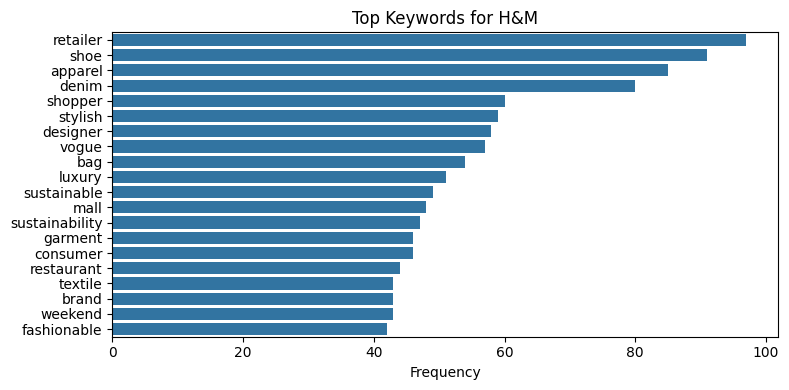

In [ ]:
# Selected brand
brand = "H&M"
keywords = dict(top_brand_keywords[brand])

plt.figure(figsize=(8,4))
sns.barplot(x=list(keywords.values()), y=list(keywords.keys()))
plt.title(f"Top Keywords for {brand}")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
brand = "H&M"
filtered_keywords = [kw for kw in brand_keywords[brand] if kw not in neutral_words]

# Counter to Dataframe
keyword_counts = Counter(filtered_keywords)
df_top_keywords_hm = pd.DataFrame(keyword_counts.most_common(40), columns=["keyword", "count"])

df_top_keywords_hm

,keyword,count
0,retailer,97
1,shoe,91
2,apparel,85
3,denim,80
4,shopper,60
5,stylish,59
6,designer,58
7,vogue,57
8,bag,54
9,luxury,51


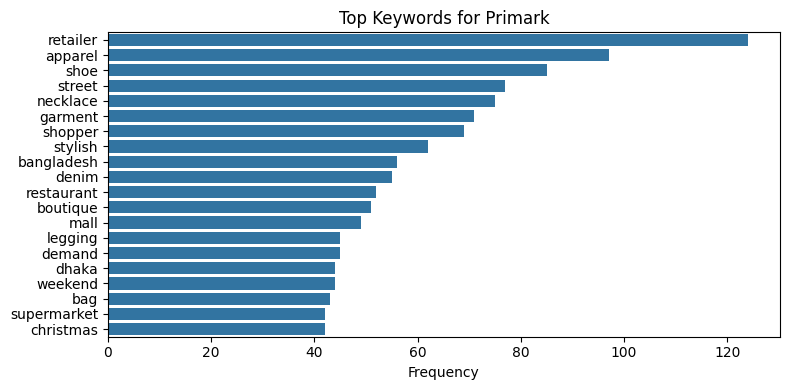

In [ ]:
# Selected brand
brand = "Primark"
keywords = dict(top_brand_keywords[brand])

plt.figure(figsize=(8,4))
sns.barplot(x=list(keywords.values()), y=list(keywords.keys()))
plt.title(f"Top Keywords for {brand}")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
brand = "Primark"
filtered_keywords = [kw for kw in brand_keywords[brand] if kw not in neutral_words]

# Counter to Dataframe
keyword_counts = Counter(filtered_keywords)
df_top_keywords_primark = pd.DataFrame(keyword_counts.most_common(40), columns=["keyword", "count"])

df_top_keywords_primark

,keyword,count
0,retailer,124
1,apparel,97
2,shoe,85
3,street,77
4,necklace,75
5,garment,71
6,shopper,69
7,stylish,62
8,bangladesh,56
9,denim,55


In [ ]:
# Add a new column named 'brand' to each dataframe to identify the brand before merging
df_top_keywords_zara['brand'] = 'Zara'
df_top_keywords_hm['brand'] = 'H&M'
df_top_keywords_primark['brand'] = 'Primark'

# Combine all three dataframes into one, stacking them vertically
df_all = pd.concat([
    df_top_keywords_zara,
    df_top_keywords_hm,
    df_top_keywords_primark
], ignore_index=True)  # Reset index to avoid duplicate index values

# Create a pivot table to see how each keyword is distributed across the brands
pivot_df = df_all.pivot_table(
    index='keyword',        # Each row represents a unique keyword
    columns='brand',        # Each column represents a brand (Zara, H&M, Primark)
    values='count',         # Cell values represent the count of the keyword
    fill_value=0            # Fill missing values with 0 (i.e., keyword not present for that brand)
).reset_index()

# Filter: Find keywords that appear in all three brands
common_keywords = pivot_df[
    (pivot_df['Zara'] > 0) & (pivot_df['H&M'] > 0) & (pivot_df['Primark'] > 0)
].sort_values(by=['Zara', 'H&M', 'Primark'], ascending=False)  # Sort to show most common first

# Filter: Find keywords that appear in only one brand (i.e., unique to a brand)
unique_keywords = pivot_df[
    ((pivot_df['Zara'] > 0).astype(int) +      # Convert boolean to int (True → 1, False → 0)
     (pivot_df['H&M'] > 0).astype(int) +
     (pivot_df['Primark'] > 0).astype(int)) == 1  # Sum should be 1 → means keyword appears in only one brand
]

In [ ]:
# Create HTML layout with side-by-side display and section headers
html_output = f"""
<h2>Keyword Comparison Across Brands</h2>

<div style="display: flex; gap: 40px;">

  <div style="flex: 1;">
    <h3>Common Keywords (All Brands)</h3>
    {common_keywords.to_html(index=False)}
  </div>

  <div style="flex: 1;">
    <h3>Unique Keywords (Only One Brand)</h3>
    {unique_keywords.to_html(index=False)}
  </div>

</div>
"""

display(HTML(html_output))

brand,keyword,H&M,Primark,Zara
,retailer,97.0,124.0,210.0
,apparel,85.0,97.0,208.0
,shoe,91.0,85.0,192.0
,denim,80.0,55.0,159.0
,sneaker,37.0,29.0,135.0
,brand,43.0,34.0,124.0
,consumer,46.0,42.0,122.0
,luxury,51.0,33.0,121.0
,restaurant,44.0,52.0,120.0
,bag,54.0,43.0,116.0


## Heatmap of Top Keywords

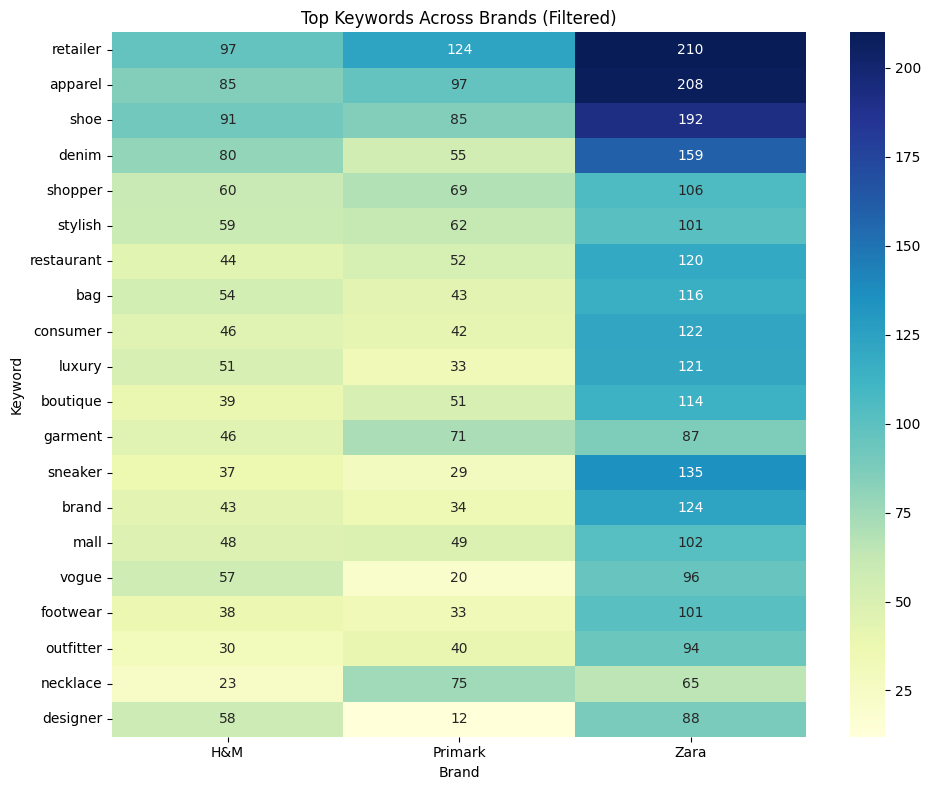

In [ ]:
# Create a long-form DataFrame with brand, keyword, and count
brand_keyword_df = pd.DataFrame([
    (brand, kw, count)
    for brand, kws in brand_keywords.items()  # brand_keywords: dict of brand → list of keywords
    for kw, count in Counter(kws).items()     # count keywords for each brand
    if kw not in neutral_words                # exclude neutral words
], columns=['brand', 'kw', 'count'])          # name the columns

# Pivot to make a matrix: rows = keywords, columns = brands, values = counts
pivot = brand_keyword_df.pivot_table(
    index='kw', columns='brand', values='count', fill_value=0
)

# Select top 20 keywords by total count across all brands
top_keywords = pivot.sum(axis=1).sort_values(ascending=False).head(20).index
pivot = pivot.loc[top_keywords]  # Filter to keep only top keywords

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title("Top Keywords Across Brands (Filtered)")
plt.ylabel("Keyword")
plt.xlabel("Brand")
plt.tight_layout()
plt.show()


## Keyword Word Cloud - Overall top keyword

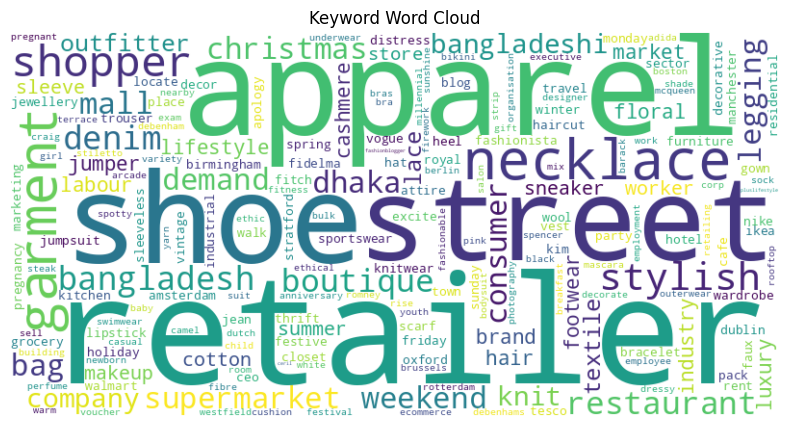

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Keyword Word Cloud")
plt.show()

## Keyword Word Cloud per Brand, filtering out common word

> Add blockquote



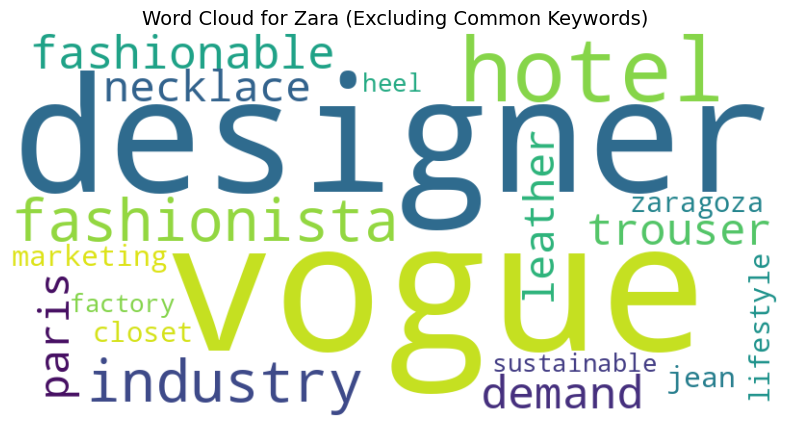

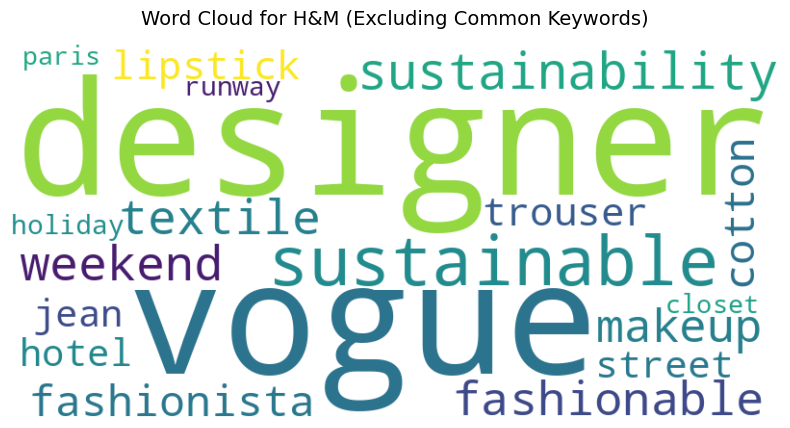

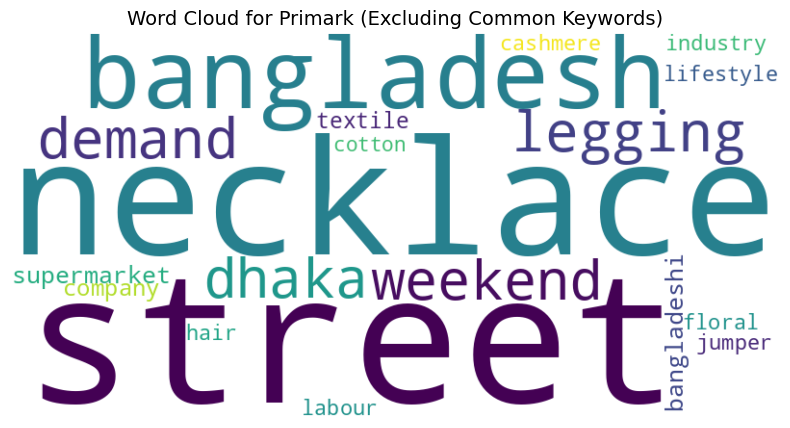

In [ ]:
# Combine all dataframes
df_all = pd.concat([df_top_keywords_zara, df_top_keywords_hm, df_top_keywords_primark], ignore_index=True)

# Filter out common keywords
df_filtered = df_all[~df_all['keyword'].isin(common_keywords['keyword'])]

# Function to generate word cloud per brand
def generate_wordcloud(df, brand_name):
    brand_df = df[df['brand'] == brand_name]
    word_freq = dict(zip(brand_df['keyword'], brand_df['count']))
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word Cloud for {brand_name} (Excluding Common Keywords)', fontsize=14)
    plt.axis('off')
    plt.show()

# Generate word clouds
for brand in ['Zara', 'H&M', 'Primark']:
    generate_wordcloud(df_filtered, brand)


# 5 Sentiment Classification and Modelling

Due to polarity from VADER is too weak, this time the project will replace with sentiment engine from Hugging face (more Advanced techniques to see the sentiment from each brand). In this project, two sentiment model have been used

Methods
- Uses Hugging Face Transformers
- Loads a pretrained model via Hugging Face Hub
- Applies pipeline() to abstract away tokenizer/model handling
- Returns label and score per input
- Commonly used in production-ready sentiment tasks

## First Sentiment Model

#### Sentiment Engine; [Twitter-roBERTa-base for Sentiment Analysis - UPDATED (2022)](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)
**`cardiffnlp/twitter-roberta-base-sentiment-latest`**

This model is a fine-tuned version of the RoBERTa-base architecture specifically adapted for sentiment analysis on social media content, particularly Twitter. It has been trained on approximately 124 million tweets collected between January 2018 and December 2021. The model was fine-tuned using the TweetEval benchmark, which is widely used for evaluating sentiment classification tasks on short-form and informal text for retail sentiment.


- Fine-tuned on approximately 124 million tweets, making it well-suited for short, informal, and noisy web content.
- Trained using the TweetEval benchmark, widely accepted for sentiment classification.
- Adaptable to a variety of content types including editorial, blog posts, and general online discourse.
- Seamlessly integrates with the Hugging Face `pipeline()` for efficient implementation.
- The RoBERTa-based model is broad generalization capabilities and training on diverse social media content. Possible to apply more to non-review data


### Key Characteristics

- **Base Architecture**: RoBERTa-base (pretrained transformer model by Facebook AI)
- **Training Data**: ~124M tweets (Jan 2018 – Dec 2021)
- **Task**: Sentiment analysis (text classification)
- **Fine-tuning Benchmark**: TweetEval
- **Language**: English

### Label Mapping

The model produces sentiment scores using the following label mapping:

- `0` → Negative  
- `1` → Neutral  
- `2` → Positive

When used via the Hugging Face `transformers` pipeline with `pipeline("sentiment-analysis", model=...)`, it automatically maps these internal numeric labels to descriptive class names (e.g., `label='positive'`).



With Confidence features in RoBERTa Sentiment Classification when using Hugging Face sentiment models like `cardiffnlp/twitter-roberta-base-sentiment-latest`,  
each prediction includes confidence score: the model’s confidence in its prediction (also called **confidence probability**)

### Use Cases

- Sentiment classification for brand monitoring
- Social media opinion mining
- Public sentiment tracking over time
- Fine-grained analysis in retail, politics, and events

### Integration

This model is fully integrated into the Hugging Face `transformers` library and can be loaded with:


## Limitations of `cardiffnlp/twitter-roberta-base-sentiment-latest`

- **English-Only Support**  
  The model is trained exclusively on English tweets and does not support other languages.

- **Limited Contextual Understanding**  
  It may misinterpret sarcasm, irony, idioms, or other nuanced language elements.

- **Training Data Constraints**  
  Based on tweets from 2018–2021; may not reflect recent slang or language trends.

- **Token Limitations**  
  Can only process up to 512 tokens per input. Longer texts are truncated, possibly omitting important context.

- **Preprocessing Requirements**  
  Inputs should replace usernames with `@user` and URLs with `http` for accurate results, matching the format used during training.

- **Domain Specificity**  
  Optimized for Twitter content—performance may degrade on data outside this domain (e.g., formal text, customer reviews).



In [ ]:
# Copy the original DataFrame
df_robert = df.copy()

In [ ]:
# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define sentiment labels
sentiment_labels = ['negative', 'neutral', 'positive']

# Function to get sentiment and confidence
def get_sentiment_with_confidence(text):
    text = str(text).strip().replace('\n', ' ')
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output.logits[0].numpy()
    probs = softmax(scores)
    pred_index = probs.argmax()
    return sentiment_labels[pred_index], float(probs[pred_index])

# Apply function with progress bar
tqdm.pandas(desc="Processing sentiments")
df_robert[['sentiment', 'confidence']] = df_robert['content'].progress_apply(
    lambda x: pd.Series(get_sentiment_with_confidence(x))
)

# View result
print(df_robert[['content', 'sentiment', 'confidence']])


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Processing sentiments: 100%|██████████| 10800/10800 [3:26:23<00:00,  1.15s/it]

                                                 content sentiment  confidence
0      plain editorial cartoonist watch debate tonigh...   neutral    0.876824
1      season frilled jacquard trouser cute easy matc...   neutral    0.593485
2      recipe zarah zanon tasty dish easy make delici...  positive    0.772406
3      world religion discuss nature life begin man j...   neutral    0.876667
4      twitter update youtube response yele haiti dra...   neutral    0.863842
...                                                  ...       ...         ...
10795  people sweater similar style pant heel fabulou...   neutral    0.609306
10796  hey guy excite announce correspondent ask well...  positive    0.906218
10797  avoid pull fast harder care admit cheap conven...   neutral    0.761215
10798  avoid pull fast harder care admit cheap conven...   neutral    0.761215
10799  contact folk clark invitation upcoming press p...  negative    0.536097

[10800 rows x 3 columns]


In [ ]:
df_robert.head()

,url,content,timestamp,year,month,day,full_date,time,url_host,url_domain,url_path,has_ugc_keyword,url_tld,page_length,brand_name,mention_count,sentiment,confidence
0,http://dgettalar.ru/index.php?n=25&id=287606,plain editorial cartoonist watch debate tonigh...,2018-10-15 17:02:05,2018,10,15,2018-10-15,18:02:05,dgettalar.ru,ru/index.php,/index.php,False,ru,659,Zara,1,neutral,0.876824
1,http://www.adayofstyle.com/new-blog/2016/11/16...,season frilled jacquard trouser cute easy matc...,2019-03-18 21:38:57,2019,3,18,2019-03-18,21:38:57,www.adayofstyle.com,adayofstyle.com,/new-blog/2016/11/16/zara-pants,False,com,55,Zara,3,neutral,0.593485
2,https://happyearthpeople.com/2019/01/18/cleans...,recipe zarah zanon tasty dish easy make delici...,2020-09-18 10:10:56,2020,9,18,2020-09-18,11:10:56,happyearthpeople.com,happyearthpeople.com,/2019/01/18/cleanse-approved-green-goodness-ch...,False,com,429,Zara,2,positive,0.772406
3,https://english.ratopati.com/story/9904,world religion discuss nature life begin man j...,2022-09-24 19:37:28,2022,9,24,2022-09-24,20:37:28,english.ratopati.com,ratopati.com,/story/9904,False,com,1087,Zara,1,neutral,0.876667
4,http://www.turkeymonkey.com/2010/01/25/teds-tw...,twitter update youtube response yele haiti dra...,2019-09-15 15:31:13,2019,9,15,2019-09-15,16:31:13,www.turkeymonkey.com,turkeymonkey.com,/2010/01/25/teds-twitter-updates-for-2010-01-25/,False,com,1189,Zara,1,neutral,0.863842


In [ ]:
output_path = Path("data/csv_data/robert-sentiment.csv")
df_robert.to_csv(output_path, index=False)

In [ ]:
df_robert = pd.read_csv(output_path)

In [ ]:
# Filtering only high confidence score
df_filtered_robert = df_robert[df_robert['confidence'] >= 0.75].copy()

In [ ]:
df_filtered_robert.head()

,url,content,timestamp,year,month,day,full_date,time,url_host,url_domain,url_path,has_ugc_keyword,url_tld,page_length,brand_name,mention_count,sentiment,confidence
0,http://dgettalar.ru/index.php?n=25&id=287606,plain editorial cartoonist watch debate tonigh...,2018-10-15 17:02:05,2018,10,15,2018-10-15,18:02:05,dgettalar.ru,ru/index.php,/index.php,False,ru,659,Zara,1,neutral,0.876824
2,https://happyearthpeople.com/2019/01/18/cleans...,recipe zarah zanon tasty dish easy make delici...,2020-09-18 10:10:56,2020,9,18,2020-09-18,11:10:56,happyearthpeople.com,happyearthpeople.com,/2019/01/18/cleanse-approved-green-goodness-ch...,False,com,429,Zara,2,positive,0.772406
3,https://english.ratopati.com/story/9904,world religion discuss nature life begin man j...,2022-09-24 19:37:28,2022,9,24,2022-09-24,20:37:28,english.ratopati.com,ratopati.com,/story/9904,False,com,1087,Zara,1,neutral,0.876667
4,http://www.turkeymonkey.com/2010/01/25/teds-tw...,twitter update youtube response yele haiti dra...,2019-09-15 15:31:13,2019,9,15,2019-09-15,16:31:13,www.turkeymonkey.com,turkeymonkey.com,/2010/01/25/teds-twitter-updates-for-2010-01-25/,False,com,1189,Zara,1,neutral,0.863842
5,http://www.rusliterature.org/the-tale-of-batus...,tale capture ryazan tale capture ryazan docume...,2018-08-14 12:50:37,2018,8,14,2018-08-14,13:50:37,www.rusliterature.org,rusliterature.org,/the-tale-of-batus-capture-of-ryazan/,False,org,2567,Zara,6,neutral,0.765358


## Sentiment Distribution Per Brand

In [ ]:
# Filter out neutral sentiment
df_pos_neg = df_filtered_robert[df_filtered_robert['sentiment'].isin(['positive', 'negative'])]

# Count sentiment per brand
counts = df_pos_neg.groupby(['brand_name', 'sentiment']).size().reset_index(name='count')

# Compute total counts per brand
counts['total'] = counts.groupby('brand_name')['count'].transform('sum')

# Compute percentage
counts['percentage'] = (counts['count'] / counts['total']) * 100

# Final summary table
summary_df = counts[['brand_name', 'sentiment', 'percentage']]
summary_df

,brand_name,sentiment,percentage
0,H&M,negative,1.677852
1,H&M,positive,98.322148
2,Primark,negative,2.960526
3,Primark,positive,97.039474
4,Zara,negative,3.232759
5,Zara,positive,96.767241


## Average Confidence Per Sentiment Type

In [ ]:
# Create pivot table for average confidence score
avg_confidence_table = df_filtered_robert.pivot_table(
    index='sentiment',
    columns='brand_name',
    values='confidence',
    aggfunc='mean'
)

# Format as percentage with 2 decimal places
avg_confidence_table = (avg_confidence_table * 100).applymap(lambda x: f"{x:.2f}%")

# Display the table
print("Average Confidence Score per Sentiment and Brand:\n")
print(avg_confidence_table)

Average Confidence Score per Sentiment and Brand:

brand_name     H&M Primark    Zara
sentiment                         
negative    81.87%  78.74%  78.06%
neutral     83.06%  84.00%  83.93%
positive    85.77%  85.73%  86.85%


<ipython-input-21-ca7637163190>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  avg_confidence_table = (avg_confidence_table * 100).applymap(lambda x: f"{x:.2f}%")


## NSS score by brand


In [ ]:
# Count sentiment occurrences per brand
sentiment_counts = df_filtered_robert.groupby(['brand_name', 'sentiment']).size().unstack(fill_value=0)

# Calculate total mentions per brand
sentiment_counts['total'] = sentiment_counts.sum(axis=1)

# Calculate percentages
sentiment_counts['%positive'] = (sentiment_counts.get('positive', 0) / sentiment_counts['total']) * 100
sentiment_counts['%negative'] = (sentiment_counts.get('negative', 0) / sentiment_counts['total']) * 100

# Calculate NSS
sentiment_counts['NSS'] = sentiment_counts['%positive'] - sentiment_counts['%negative']

# Format NSS as percentage with 2 decimal places
sentiment_counts['NSS'] = sentiment_counts['NSS'].map(lambda x: f"{x:.2f}%")

# Display only NSS per brand
nss_scores = sentiment_counts[['NSS']]

print("Net Sentiment Score (NSS) per Brand:\n")
print(nss_scores)

Net Sentiment Score (NSS) per Brand:

sentiment      NSS
brand_name        
H&M         25.24%
Primark     25.88%
Zara        13.39%


## Brand-wise Confidence Score Distribution

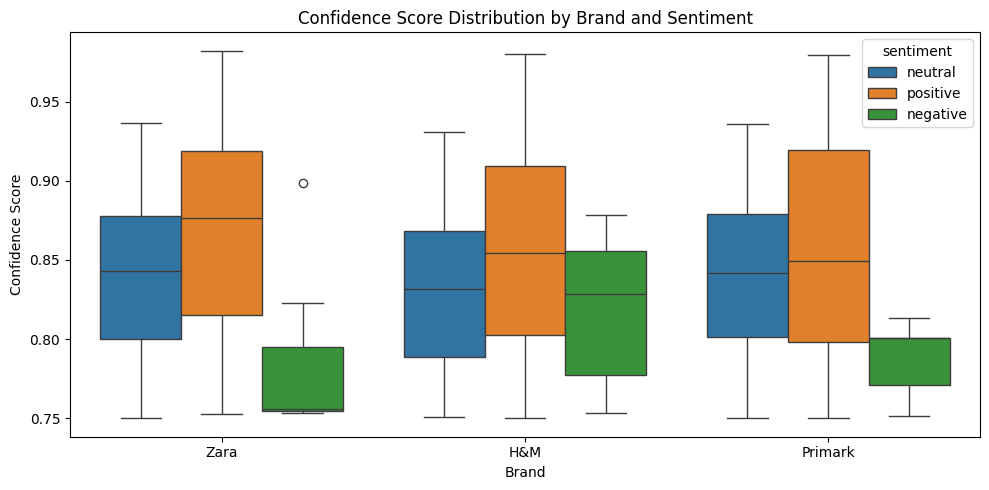

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_filtered_robert, x='brand_name', y='confidence', hue='sentiment')
plt.title('Confidence Score Distribution by Brand and Sentiment')
plt.xlabel('Brand')
plt.ylabel('Confidence Score')
plt.tight_layout()
plt.show()

No insigth gains from this sentiment engine

## Second Sentiment Model


**`DistilBERT Clothing Review Model`**

- Specifically trained on customer reviews from a structured dataset. Even it seems suitable but the content features are generic one and unstructured text
- Optimized for opinion mining in product feedback rather than unstructured website or article content.
- Narrow domain scope may lead to reduced performance on broader fashion-related discussions.

In [ ]:
df_robert.head()

# Limitations of `ongaunjie/distilbert-cloths-sentiment`

- **Domain-specific training**  
  The model is fine-tuned on women's clothing reviews, so it may underperform on other domains such as electronics or general social media text.

- **Limited label set**  
  The sentiment classification is limited to three categories: `positive`, `neutral`, and `negative`. It does not support nuanced sentiment like sarcasm, mixed emotion, or multi-aspect sentiment.

- **Short to medium text**  
  It performs best on short to medium-length reviews (1-3 sentences). Long product descriptions or multi-topic paragraphs may be truncated or misclassified.

- **English-only**  
  The model is trained on English text and may not generalize well to other languages or multilingual content.

- **No aspect-based sentiment**  
  It does not identify sentiment by product features (e.g., "quality is good but size is small"), which is often required in fine-grained retail analysis.

- **Batch inference may vary**  
  On large batches or very noisy input, the model may return inconsistent results or fail unless preprocessed properly.


In [ ]:
# Copy the original DataFrame
df_bert = df.copy()

In [ ]:
# Load model and tokenizer
model_name = "ongaunjie/distilbert-cloths-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Get sentiment labels from the model config
sentiment_labels = model.config.id2label.values()

# Function to get sentiment and confidence
def get_sentiment_with_confidence(text):
    text = str(text).strip().replace('\n', ' ')
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output.logits[0].numpy()
    probs = softmax(scores)
    pred_index = probs.argmax()
    return list(sentiment_labels)[pred_index], float(probs[pred_index])

# Apply with progress bar
tqdm.pandas(desc="Analyzing sentiment")
df_bert[['sentiment', 'confidence']] = df_bert['content'].progress_apply(
    lambda x: pd.Series(get_sentiment_with_confidence(x))
)

# Display results
print(df_bert[['content', 'sentiment', 'confidence']])


tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Analyzing sentiment:   0%|          | 0/10800 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Analyzing sentiment: 100%|██████████| 10800/10800 [1:39:45<00:00,  1.80it/s]

                                                 content sentiment  confidence
0      plain editorial cartoonist watch debate tonigh...   LABEL_2    0.999470
1      season frilled jacquard trouser cute easy matc...   LABEL_2    0.999775
2      recipe zarah zanon tasty dish easy make delici...   LABEL_2    0.999823
3      world religion discuss nature life begin man j...   LABEL_1    0.980585
4      twitter update youtube response yele haiti dra...   LABEL_2    0.981507
...                                                  ...       ...         ...
10795  people sweater similar style pant heel fabulou...   LABEL_2    0.999874
10796  hey guy excite announce correspondent ask well...   LABEL_2    0.999873
10797  avoid pull fast harder care admit cheap conven...   LABEL_2    0.999827
10798  avoid pull fast harder care admit cheap conven...   LABEL_2    0.999827
10799  contact folk clark invitation upcoming press p...   LABEL_2    0.999856

[10800 rows x 3 columns]


In [ ]:

df_robert.to_csv(output_path, index=False)
df_robert = pd.read_csv(output_path)

In [ ]:
output_path = Path("data/csv_data/bert-sentiment.csv")
df_bert.to_csv(output_path, index=False)

In [ ]:
df_bert = pd.read_csv(output_path)

In [ ]:
df_bert.head()

,url,content,timestamp,year,month,day,full_date,time,url_host,url_domain,url_path,has_ugc_keyword,url_tld,page_length,brand_name,mention_count,sentiment,confidence
0,http://dgettalar.ru/index.php?n=25&id=287606,plain editorial cartoonist watch debate tonigh...,2018-10-15 17:02:05,2018,10,15,2018-10-15,18:02:05,dgettalar.ru,ru/index.php,/index.php,False,ru,659,Zara,1,LABEL_2,0.999470
1,http://www.adayofstyle.com/new-blog/2016/11/16...,season frilled jacquard trouser cute easy matc...,2019-03-18 21:38:57,2019,3,18,2019-03-18,21:38:57,www.adayofstyle.com,adayofstyle.com,/new-blog/2016/11/16/zara-pants,False,com,55,Zara,3,LABEL_2,0.999775
2,https://happyearthpeople.com/2019/01/18/cleans...,recipe zarah zanon tasty dish easy make delici...,2020-09-18 10:10:56,2020,9,18,2020-09-18,11:10:56,happyearthpeople.com,happyearthpeople.com,/2019/01/18/cleanse-approved-green-goodness-ch...,False,com,429,Zara,2,LABEL_2,0.999823
3,https://english.ratopati.com/story/9904,world religion discuss nature life begin man j...,2022-09-24 19:37:28,2022,9,24,2022-09-24,20:37:28,english.ratopati.com,ratopati.com,/story/9904,False,com,1087,Zara,1,LABEL_1,0.980585
4,http://www.turkeymonkey.com/2010/01/25/teds-tw...,twitter update youtube response yele haiti dra...,2019-09-15 15:31:13,2019,9,15,2019-09-15,16:31:13,www.turkeymonkey.com,turkeymonkey.com,/2010/01/25/teds-twitter-updates-for-2010-01-25/,False,com,1189,Zara,1,LABEL_2,0.981507


**Further Hypothesis**: The sentiment score derived from the pretrained dataset might be positively correlated with the LLM's brand preference as expressed in its responses.

In [ ]:
# Filtering only high confidence score
df_filtered_bert = df_bert[df_bert['confidence'] >= 0.75].copy()

In [ ]:
df_filtered_bert.head()

,url,content,timestamp,year,month,day,full_date,time,url_host,url_domain,url_path,has_ugc_keyword,url_tld,page_length,brand_name,mention_count,sentiment,confidence
0,http://dgettalar.ru/index.php?n=25&id=287606,plain editorial cartoonist watch debate tonigh...,2018-10-15 17:02:05,2018,10,15,2018-10-15,18:02:05,dgettalar.ru,ru/index.php,/index.php,False,ru,659,Zara,1,LABEL_2,0.999470
1,http://www.adayofstyle.com/new-blog/2016/11/16...,season frilled jacquard trouser cute easy matc...,2019-03-18 21:38:57,2019,3,18,2019-03-18,21:38:57,www.adayofstyle.com,adayofstyle.com,/new-blog/2016/11/16/zara-pants,False,com,55,Zara,3,LABEL_2,0.999775
2,https://happyearthpeople.com/2019/01/18/cleans...,recipe zarah zanon tasty dish easy make delici...,2020-09-18 10:10:56,2020,9,18,2020-09-18,11:10:56,happyearthpeople.com,happyearthpeople.com,/2019/01/18/cleanse-approved-green-goodness-ch...,False,com,429,Zara,2,LABEL_2,0.999823
3,https://english.ratopati.com/story/9904,world religion discuss nature life begin man j...,2022-09-24 19:37:28,2022,9,24,2022-09-24,20:37:28,english.ratopati.com,ratopati.com,/story/9904,False,com,1087,Zara,1,LABEL_1,0.980585
4,http://www.turkeymonkey.com/2010/01/25/teds-tw...,twitter update youtube response yele haiti dra...,2019-09-15 15:31:13,2019,9,15,2019-09-15,16:31:13,www.turkeymonkey.com,turkeymonkey.com,/2010/01/25/teds-twitter-updates-for-2010-01-25/,False,com,1189,Zara,1,LABEL_2,0.981507


In [ ]:
df_unique_sentiment = df_filtered_bert.drop_duplicates(subset='sentiment')
df_unique_sentiment

,url,content,timestamp,year,month,day,full_date,time,url_host,url_domain,url_path,has_ugc_keyword,url_tld,page_length,brand_name,mention_count,sentiment,confidence
0,http://dgettalar.ru/index.php?n=25&id=287606,plain editorial cartoonist watch debate tonigh...,2018-10-15 17:02:05,2018,10,15,2018-10-15,18:02:05,dgettalar.ru,ru/index.php,/index.php,False,ru,659,Zara,1,LABEL_2,0.999470
3,https://english.ratopati.com/story/9904,world religion discuss nature life begin man j...,2022-09-24 19:37:28,2022,9,24,2022-09-24,20:37:28,english.ratopati.com,ratopati.com,/story/9904,False,com,1087,Zara,1,LABEL_1,0.980585
628,https://allworknopay.substack.com/p/no-one-wil...,one pay much trouble raise price fear always s...,2020-10-23 20:01:19,2020,10,23,2020-10-23,21:01:19,allworknopay.substack.com,substack.com,/p/no-one-will-pay-that-much,False,com,275,Primark,1,LABEL_0,0.991930


In [ ]:
# Sentiment Categories: Neutral [0], Negative [1], Positive [2]
label_mapping = {
    'LABEL_0': 'neutral',
    'LABEL_1': 'negative',
    'LABEL_2': 'positive'
}

df_filtered_bert['sentiment'] = df_filtered_bert['sentiment'].map(label_mapping)

In [ ]:
df_filtered_bert

,url,content,timestamp,year,month,day,full_date,time,url_host,url_domain,url_path,has_ugc_keyword,url_tld,page_length,brand_name,mention_count,sentiment,confidence
0,http://dgettalar.ru/index.php?n=25&id=287606,plain editorial cartoonist watch debate tonigh...,2018-10-15 17:02:05,2018,10,15,2018-10-15,18:02:05,dgettalar.ru,ru/index.php,/index.php,False,ru,659,Zara,1,positive,0.999470
1,http://www.adayofstyle.com/new-blog/2016/11/16...,season frilled jacquard trouser cute easy matc...,2019-03-18 21:38:57,2019,3,18,2019-03-18,21:38:57,www.adayofstyle.com,adayofstyle.com,/new-blog/2016/11/16/zara-pants,False,com,55,Zara,3,positive,0.999775
2,https://happyearthpeople.com/2019/01/18/cleans...,recipe zarah zanon tasty dish easy make delici...,2020-09-18 10:10:56,2020,9,18,2020-09-18,11:10:56,happyearthpeople.com,happyearthpeople.com,/2019/01/18/cleanse-approved-green-goodness-ch...,False,com,429,Zara,2,positive,0.999823
3,https://english.ratopati.com/story/9904,world religion discuss nature life begin man j...,2022-09-24 19:37:28,2022,9,24,2022-09-24,20:37:28,english.ratopati.com,ratopati.com,/story/9904,False,com,1087,Zara,1,negative,0.980585
4,http://www.turkeymonkey.com/2010/01/25/teds-tw...,twitter update youtube response yele haiti dra...,2019-09-15 15:31:13,2019,9,15,2019-09-15,16:31:13,www.turkeymonkey.com,turkeymonkey.com,/2010/01/25/teds-twitter-updates-for-2010-01-25/,False,com,1189,Zara,1,positive,0.981507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10795,https://www.ohsoglam.com/minty-fresh/,people sweater similar style pant heel fabulou...,2022-09-25 00:46:16,2022,9,25,2022-09-25,01:46:16,www.ohsoglam.com,ohsoglam.com,/minty-fresh/,False,com,648,H&M,5,positive,0.999874
10796,http://rossanavanoni.com/shop-org-2017-corresp...,hey guy excite announce correspondent ask well...,2017-10-16 22:40:35,2017,10,16,2017-10-16,23:40:35,rossanavanoni.com,rossanavanoni.com,/shop-org-2017-correspondent/,False,com,331,H&M,1,positive,0.999873
10797,https://goodonyou.eco/how-to-switch-from-fast-...,avoid pull fast harder care admit cheap conven...,2022-09-25 08:17:55,2022,9,25,2022-09-25,09:17:55,goodonyou.eco,goodonyou.eco,/how-to-switch-from-fast-fashion-to-vintage-on...,False,eco,1290,Zara,1,positive,0.999827
10798,https://goodonyou.eco/how-to-switch-from-fast-...,avoid pull fast harder care admit cheap conven...,2022-09-25 08:17:55,2022,9,25,2022-09-25,09:17:55,goodonyou.eco,goodonyou.eco,/how-to-switch-from-fast-fashion-to-vintage-on...,False,eco,1290,Zara,1,positive,0.999827


# Sentiment Distribution per Brand

In [ ]:
# Filter out neutral sentiment
df_pos_neg = df_filtered_bert[df_filtered_bert['sentiment'].isin(['positive', 'negative'])]

# Count sentiment per brand
counts = df_pos_neg.groupby(['brand_name', 'sentiment']).size().reset_index(name='count')

# Compute total counts per brand
counts['total'] = counts.groupby('brand_name')['count'].transform('sum')

# Compute percentage
counts['percentage'] = (counts['count'] / counts['total']) * 100

# Final summary table
summary_df_bert = counts[['brand_name', 'sentiment', 'percentage']]
summary_df_bert

,brand_name,sentiment,percentage
0,H&M,negative,14.989293
1,H&M,positive,85.010707
2,Primark,negative,23.216720
3,Primark,positive,76.783280
4,Zara,negative,23.190675
5,Zara,positive,76.809325


# Average Confidence per Sentiment Type

In [ ]:
# Create pivot table for average confidence score
avg_confidence_table = df_filtered_bert.pivot_table(
    index='sentiment',
    columns='brand_name',
    values='confidence',
    aggfunc='mean'
)

# Format as percentage with 2 decimal places
avg_confidence_table = (avg_confidence_table * 100).applymap(lambda x: f"{x:.2f}%")

# Display the table
print("Average Confidence Score per Sentiment and Brand:\n")
print(avg_confidence_table)

Average Confidence Score per Sentiment and Brand:

brand_name     H&M Primark    Zara
sentiment                         
negative    96.61%  98.28%  96.56%
neutral     96.57%  95.63%  97.97%
positive    99.43%  99.20%  99.07%


<ipython-input-37-e906965eb646>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  avg_confidence_table = (avg_confidence_table * 100).applymap(lambda x: f"{x:.2f}%")


# Save as a checkpoint

In [ ]:
output_path = Path("data/csv_data/sentiment-nlp-features.csv")
df_filtered.to_csv(output_path, index=False)

## Filter rows with high confidence

In [ ]:
df_filtered = pd.read_csv(output_path)

In [ ]:
df_filtered.head()

In [ ]:
# Define threshold (high confidence)
threshold = 0.75

# Filter only rows with high confidence predictions
df_filtered = df_filtered[df_filtered['confidence'] > threshold]

## Change page length to categorical data

However, the numerical of page length still be kept

In [ ]:
df['page_length_bin'] = pd.qcut(df['page_length'], q=5, labels=['very_short', 'short', 'medium', 'long', 'very_long'])

In [ ]:
df.head()

In [ ]:
df.info()

# 6 Correlation Analysis

In [ ]:
df_corr = df.copy()

In [ ]:
# Drop irrelevant columns to do one-hot encoding
drop_cols = ['url', 'content', 'timestamp', 'full_date', 'time', 'month', 'day',
             'url_host', 'url_domain', 'url_path', 'entities', 'is_relevant', 'keywords', 'co_mentioned_brands']
df_corr.drop(columns=drop_cols, inplace=True)

In [ ]:
# One-hot encode 'brand_name', 'web_category', 'url_tld'
df_corr = pd.get_dummies(df_corr, columns=['brand_name', 'web_category', 'url_tld', 'page_length_bin', 'year'], drop_first=True)

In [ ]:
# Check data type
print(df_corr.dtypes)

In [ ]:
correlation_matrix = df_corr.corr()

# Identify brand and web feature columns
brand_cols = [col for col in df_corr.columns if col.startswith('brand_name_')]
web_feature_cols = [col for col in df_corr.columns if any(prefix in col for prefix in ['web_category_', 'url_tld_', 'page_length', 'mention_count', 'has_ugc_keyword', 'page_length_bin'])]

# Extract correlation values between brands and web features
filtered_corr = correlation_matrix.loc[brand_cols, web_feature_cols]

# Keep only values with abs(correlation) > 0.1
threshold = 0.1
high_corr_only = filtered_corr.where(filtered_corr.abs() > threshold)

# Drop rows and columns where all values are NaN (i.e., below threshold)
high_corr_only.dropna(how='all', axis=0, inplace=True)
high_corr_only.dropna(how='all', axis=1, inplace=True)

# Plot only the high-correlation values
plt.figure(figsize=(12, 6))
sns.heatmap(high_corr_only, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title(f'Correlation (|r| > {threshold}): Brand Name vs Web Characteristics')
plt.tight_layout()
plt.show()


In [ ]:
# Compute correlation
correlation_matrix = df_corr.corr()

# Identify brand and web feature columns
brand_cols = [col for col in df_corr.columns if col.startswith('brand_name_')]
web_feature_cols = [col for col in df_corr.columns if any(prefix in col for prefix in ['web_category_', 'url_tld_', 'page_length', 'mention_count', 'has_ugc_keyword'])]

# Filter correlation matrix
filtered_corr = correlation_matrix.loc[brand_cols, web_feature_cols]

# Only keep columns with at least one correlation > threshold (absolute)
threshold = 0.1
important_corr = filtered_corr.loc[:, (filtered_corr.abs() > threshold).any()]

# Visualize the filtered matrix
plt.figure(figsize=(12, 6))
sns.heatmap(important_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Filtered Correlation: Brand Name vs Significant Web Characteristics')
plt.tight_layout()
plt.show()


# 7 Hypothesis Testing

As monitoring DeepSeek response and match the pattern to gain insights. The Framework of Hypothesis has been developed to analyze the pretrained dataset

### Correlation Methods Used For hypothesis testing

| Method     | Use Case                                    | Assumptions                            |
|------------|---------------------------------------------|-----------------------------------------|
| **Pearson**  | Measures linear correlation between numeric values | Requires normal distribution and linearity |
| **Spearman** | Measures correlation based on rank order     | **Non-parametric** (no distribution assumptions) |

### Why Spearman?

Given the **small sample size (n = 3 brands)** and the potential **non-linear** nature of relationships, **Spearman is more appropriate**. It evaluates whether increases in one variable are associated with consistent changes in the ranking of the other — making it **robust and conservative** for this use case.


## Generic Prompt for brand ranking and Specific brand provided

<div style="
    background-color: #e7f3fe;
    border-left: 6px solid #2196F3;
    padding: 20px;
    font-family: Arial, sans-serif;
    font-size: 1000px;">
    💡 <b>Note:</b> Due to small sample size (n=3), <code>p-value</code> is mostly not statistically significant. statistical significance cannot be established. The observed correlation (r = ...) should be interpreted as exploratory insight rather than conclusive evidence.

</div>


**Disclaimer: This time, the p-value will not be considered due to extreamely small sample size,  Correlation results are exploratory and serve to illustrate directional trends, not confirm causal or predictive relationships.**

## Hypothesis testing 1 - Token Frequency (sum of mention_count) Correlates with Rank Stability

Goal; Online presence measuring via Token count (mention_count) impact the higher LLM ranking

With General asking in LLM for brand ranking (DeepSeek), Below are categorized as the top rank. This will be the fixed rank as testing until the prompt changes

In [ ]:
df_hypo = df.copy()

In [ ]:
# Define static ranking: lower rank = better - as try with DeepSeep Response
static_rank_data = [
    ("Zara", 1),
    ("H&M", 2),
    ("Primark", 3)
]

**Assumption**; Brands that appear frequently in pretraining data, measured via total token/mention count, may be ranked higher by LLMs, regardless of the surrounding context or semantic framing.

**Metric Used**:
- mention_count (sum) = proxy for token frequency
- avg_rank = fixed brand ranking (lower is better)

In [ ]:
# Group by brand_name to get total mentions and number of rows with each brand
mention_counts_df = df_hypo.groupby("brand_name").agg(
    mention_count=('mention_count', 'sum'),
    brand_occurrence_count=('brand_name', 'count')
).reset_index()

mention_counts_df

In [ ]:
# Static Rank info
rank_df = pd.DataFrame(static_rank_data, columns=["brand_name", "avg_rank"])

# Merge mention counts with rank info
joined_df = pd.merge(mention_counts_df, rank_df, on="brand_name")


# Spearman Correlation: Total Mention Count vs LLM Rank
corr_s1, pval_s1 = spearmanr(joined_df["mention_count"], joined_df["avg_rank"])
print(f"Spearman Correlation (mention count vs rank): r = {corr_s1:.3f}, p = {pval_s1:.3f}")

# Scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=joined_df, x="mention_count", y="avg_rank", s=120, color="royalblue")

# Annotate points
for _, row in joined_df.iterrows():
    plt.text(row["mention_count"], row["avg_rank"] + 0.1, row["brand_name"], ha='center', fontsize=10)

plt.title("Total Mention Count vs Brand Rank", fontsize=14)
plt.xlabel("Total Mention Count", fontsize=12)
plt.ylabel("Average Rank (Lower = Better)", fontsize=12)
plt.gca().invert_yaxis()  # Lower rank (1) at the top
plt.grid(True)
plt.tight_layout()
plt.show()

### Hypothesis Conclusion: Token Frequency vs Brand Rank
The analysis shows a moderate negative Spearman correlation (r = -0.500, p = 0.667) between total mention count and brand rank  where Zara consistently appeared as the most prominent brand, followed by H&M and Primark. The result suggests a trend where brands mentioned more frequently across web sources tend to receive higher ranking in LLM outputs.


# Bias Analysis

# Hypothesis testing 2 - Formal vs Informal Content Bias (Unsolved; high irrelevant page)

Goal; Output leans toward formal tone, likely from news/research. LLM might rank the higher rank for those brands that seems formal tone or on the reliable web page

For this hypothesis, the method is to use web_category to classify formal/informal, Calculate the proportion of content that is formal (e.g., News, Financial) vs informal (e.g., Blogs, Community).

In [ ]:
df_hypo.groupby(['brand_name', 'web_category'])['mention_count'].sum().unstack(fill_value=0)

In [ ]:
df_hypo.head()

In [ ]:
# Catogorize formal and informal cats
formal_cats = ['Education', 'Financial', 'Government', 'News']
informal_cats = ['Blogs & Community', 'Media & Entertainment', 'Social', 'Others', 'E-commerce & Commercial']

In [ ]:
total_docs = len(df_hypo)
formal_docs = df_hypo['web_category'].isin(formal_cats).sum()
formal_ratio = formal_docs / total_docs
print(f"Formal category ratio: {formal_ratio:.2%}")

In [ ]:
# Group the original DataFrame to get formal mentions only
df_formal_mentions = df_hypo[df_hypo['web_category'].isin(formal_cats)]

# Sum formal mentions per brand
df_formal_sum = df_formal_mentions.groupby('brand_name')['mention_count'].sum()

# Compute % share for each brand
df_formal_pct = df_formal_sum / df_formal_sum.sum() * 100

In [ ]:
pd.set_option('display.max_columns', None)  # Show all columns

In [ ]:
df_formal_mentions[
    df_formal_mentions['web_category'].isin(["Education", "Financial", "Government"])
][['url_host', 'url_domain']].head(10)


In [ ]:
# Visualize the Ratios
plt.figure(figsize=(6, 5))
df_formal_pct.plot(kind='bar', title='Share of Formal Mentions by Brand', ylabel='Percentage (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
static_rank_data

In [ ]:
# Map static brand ranks from LLM
static_rank_dict = dict(static_rank_data)
df_formal_pct['rank'] = df_formal_pct.index.map(static_rank_dict)

# Spearman correlation
r_spear, p_spear = spearmanr(df_formal_pct['formal_pct'], df_formal_pct['rank'])
print(f"Spearman Correlation (Formal % vs Rank): r = {r_spear:.2f}, p = {p_spear:.3f}")

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(df_formal_pct['formal_pct'], df_formal_pct['rank'], s=100)

for brand, row in df_formal_pct.iterrows():
    plt.text(row['formal_pct'] + 1, row['rank'], brand)

plt.xlabel("Share of Mentions from Formal Sources (%)")
plt.ylabel("Static Brand Rank (Lower = Better)")
plt.title("Brand Rank vs Formal Share of Mentions")
plt.gca().invert_yaxis()  # Lower rank = better
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pd.set_option('display.max_colwidth', None)

### Human Evaluation Check

The page return are irrelevant to the sentiment analysis

In [ ]:
df_formal_mentions[
    (df_formal_mentions['web_category'].isin(["Education", "Financial", "Government"])) &
    (df_formal_mentions['brand_name'] == "Zara")
][['brand_name', 'content']].head(10)

In [ ]:
fashion_keywords = [
    "dress", "clothing", "style", "fashion", "outfit", "wear",
    "collection", "trend", "runway", "model", "lookbook", "wardrobe",
    "design", "brand", "shop", "retail"
]

def contains_zara_and_3_fashion_words(text):
    if not isinstance(text, str):
        return False
    text_lower = text.lower()
    zara_match = re.search(r'\bzara\b', text_lower)
    count = sum(1 for word in fashion_keywords if word in text_lower)
    return bool(zara_match) and count >= 3

filtered_df = df_formal_mentions[
    df_formal_mentions['content'].apply(contains_zara_and_3_fashion_words)
][['brand_name', 'content']]

# Show all text in 'content'
pd.set_option('display.max_colwidth', None)
filtered_df.head(3)

# Hypothesis 3: Location Bias from TLD

Goal: Are certain brands more common in .uk, .fr, etc.?, is there any Bias in Location in LLM response

In [ ]:
crosstab_df = pd.crosstab(df_hypo['brand_name'], df_hypo['url_tld'], normalize='index')

## Heatmap for TLD

In [ ]:
# Filter top N TLDs by overall usage (column sum)
top_tlds = crosstab_df.sum(axis=0).sort_values(ascending=False).head(10).index
filtered = crosstab_df[top_tlds]

# Heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(filtered, annot=True, cmap='Blues', fmt=".2%", linewidths=0.5)
plt.title("Brand Presence Across Top 10 TLDs (Normalized by Brand)", fontsize=14)
plt.xlabel("TLD")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()

## Remove .com

In [ ]:
# Remove 'com' column first
crosstab_excl_com = crosstab_df.drop(columns='com', errors='ignore')

# Re-normalize so each row sums to 1 again (without 'com')
crosstab_excl_com = crosstab_excl_com.div(crosstab_excl_com.sum(axis=1), axis=0)

# Pick top TLDs excluding 'com' by global presence
top_tlds = crosstab_excl_com.sum(axis=0).sort_values(ascending=False).head(10).index
filtered = crosstab_excl_com[top_tlds]

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(filtered, annot=True, cmap='Blues', fmt=".2%", linewidths=0.5)
plt.title("Brand Presence Across Top TLDs (Excluding .com, Normalized by Brand)", fontsize=14)
plt.xlabel("TLD")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()

## Top-Level Domain (TLD) Descriptions

Below are brief descriptions of each TLD extracted from the image:

- **.co.uk**: United Kingdom – Used by commercial entities based in the UK.
- **.org**: Organization – Commonly used by non-profit and non-governmental organizations.
- **.net**: Network – Originally for network providers, now broadly used.
- **.co**: Colombia – Country-code TLD often marketed globally for “company”.
- **.ca**: Canada – The official country code TLD for Canada.
- **.info**: Information – Generic TLD intended for informational websites.
- **.com.au**: Australia – Commercial organizations in Australia.
- **.ie**: Ireland – Country code TLD for Ireland.
- **.ru**: Russia – Country code TLD for the Russian Federation.
- **.in**: India – Country code TLD for India.


For all details of top-level domains, including gTLDs worldwide, please see [Link](https://www.iana.org/domains/root/db).

## Stacked Bar Chart (% distribution per brand)

In [ ]:
# Transpose so each brand's row becomes a stacked column
filtered.T.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='tab20c')
plt.title("Distribution of Brands Across Top TLDs")
plt.ylabel("Proportion of URLs")
plt.xticks(rotation=45)
plt.legend(title="Brand", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Check False Postiive of org content
filtered_df = df_hypo[df_hypo['url_tld'] == 'uk'][['brand_name', 'content','url', 'url_tld']]
filtered_df.head(20)

In [ ]:
# Check False Postiive of org content
filtered_df = df_hypo[df_hypo['url_tld'] == 'org'][['brand_name', 'content','url', 'url_tld']]
filtered_df.head(10)

## Hypothesis 4: Revenue Context Bias

Goal: Check if top-ranked brands co-occur with financial context or not as Reasoning model prioritize the market value, Revenue, Financial statement. The response related to the numerical figures

In this hypothesis, the ranking based on **R1 model** will be highlihgted due to the nature of reasoning model and understanding forcus

In [ ]:
df_hypo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10021 entries, 0 to 10020
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   url                  10021 non-null  object
 1   content              10021 non-null  object
 2   timestamp            10021 non-null  object
 3   year                 10021 non-null  int64 
 4   month                10021 non-null  int64 
 5   day                  10021 non-null  int64 
 6   full_date            10021 non-null  object
 7   time                 10021 non-null  object
 8   url_host             10021 non-null  object
 9   url_domain           10021 non-null  object
 10  url_path             10021 non-null  object
 11  has_ugc_keyword      10021 non-null  bool  
 12  url_tld              10021 non-null  object
 13  page_length          10021 non-null  int64 
 14  brand_name           10021 non-null  object
 15  mention_count        10021 non-null  int64 
 16  enti

In [ ]:
financial_keywords = [
    'revenue', 'billion', 'million', 'sales', 'usd', '£',
    'profit', 'net income', 'earnings', 'financial statement', 'market value'
]

df_hypo['contains_financial_context'] = df_hypo['content'].str.lower().apply(
    lambda text: any(keyword in text for keyword in financial_keywords)
)

df_hypo['content_word_count'] = df_hypo['content'].str.split().str.len()

brand_context_bias = df_hypo.groupby('brand_name').agg(
    total_mentions=('content', 'count'),
    financial_context_mentions=('contains_financial_context', 'sum'),
    avg_word_count=('content_word_count', 'mean'),
    avg_word_count_financial=('content_word_count', lambda x: x[df_hypo.loc[x.index, 'contains_financial_context']].mean())
)

brand_context_bias['pct_financial_context'] = (
    brand_context_bias['financial_context_mentions'] / brand_context_bias['total_mentions']
) * 100

brand_context_bias_sorted = brand_context_bias.sort_values(by='pct_financial_context', ascending=False)

# Round numeric columns to 2 decimals
brand_context_bias_sorted = brand_context_bias_sorted.round(2)

# Format percentage with % sign
brand_context_bias_sorted['pct_financial_context'] = brand_context_bias_sorted['pct_financial_context'].astype(str) + '%'

# Display
display(brand_context_bias_sorted.head(10))


,total_mentions,financial_context_mentions,avg_word_count,avg_word_count_financial,pct_financial_context
brand_name,,,,,
Zara,5596,1433,1066.42,2671.95,25.61%
Primark,2195,466,887.89,2350.49,21.23%
H&M,2230,431,472.20,1360.15,19.33%


Spearman Correlation (Financial Context % vs Rank): r = -0.50, p = 0.667


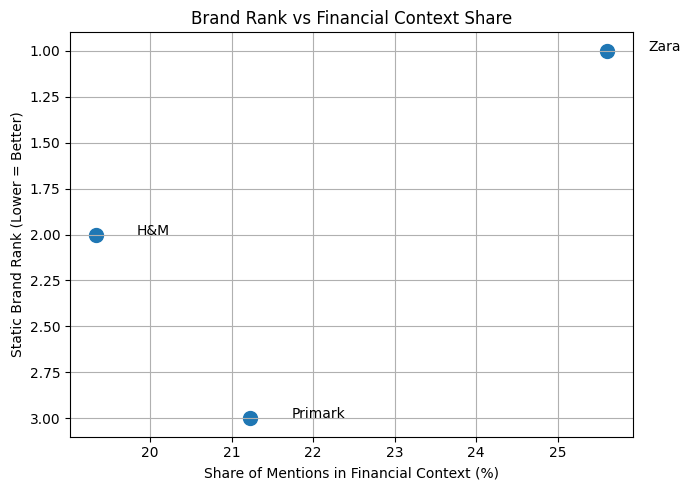

In [ ]:
# Prepare bias dataframe
financial_bias_df = brand_context_bias_sorted.copy()
financial_bias_df['pct_financial_context'] = financial_bias_df['pct_financial_context'].str.replace('%', '').astype(float)
financial_bias_df['rank'] = financial_bias_df.index.map(static_rank_dict)

# Drop any brands not in the rank list
financial_bias_df = financial_bias_df.dropna(subset=['rank'])

# Spearman correlation
r_spear, p_spear = spearmanr(financial_bias_df['pct_financial_context'], financial_bias_df['rank'])
print(f"Spearman Correlation (Financial Context % vs Rank): r = {r_spear:.2f}, p = {p_spear:.3f}")

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(financial_bias_df['pct_financial_context'], financial_bias_df['rank'], s=100)

# Annotate points
for brand, row in financial_bias_df.iterrows():
    plt.text(row['pct_financial_context'] + 0.5, row['rank'], brand)

plt.xlabel("Share of Mentions in Financial Context (%)")
plt.ylabel("Static Brand Rank (Lower = Better)")
plt.title("Brand Rank vs Financial Context Share")
plt.gca().invert_yaxis()  # Lower rank = better
plt.grid(True)
plt.tight_layout()
plt.show()


-- End of the notebook --